Global settings and import

In [1]:


from matplotlib import pyplot as plt

outputs=['RESULT_InclinationBeltDirection__deg_',
       'RESULT_Inclination90ToBeltDirection__deg_']


Import, NAN filter

In [2]:
from utils import load_raw
importer=load_raw.DataFrameImporter()
importer.load("Data","data/Data Test March.csv")
#importer.NOK_Cleaning("100k",True)
importer.NAN_Cleaning("Data")
df = importer.get_dataframe("Data")
df.head()
inclination_toBD_original=df[outputs[0]]





Outliers filter

In [27]:
from preprocess.outlier_filter import filter
df_filtered=filter(df,outputs)
inclination_toBD_original=df_filtered[outputs[0]]


c:\svn\python projects\thesis project\src\preprocess\outlier_filter.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  z_score = pd.concat([z_score, z_score_i])  # Append the result to z_score


Comparison of original and filtered data

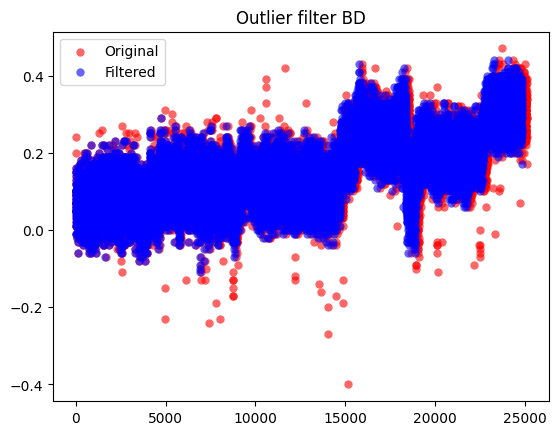

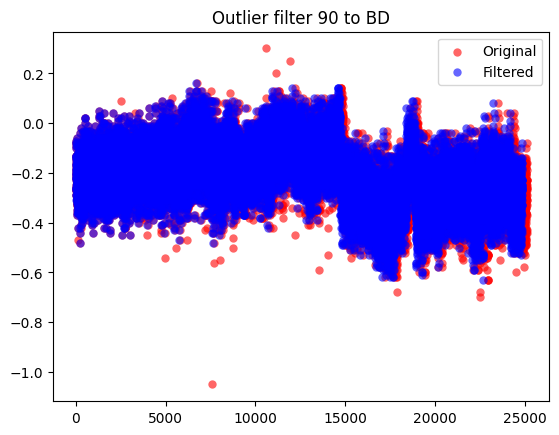

In [28]:
plt.scatter(range(len(df[outputs[0]])),df[outputs[0]].values,label="Original",alpha=0.6,linewidths=0,color='red')
plt.scatter(range(len(df_filtered[outputs[0]])),df_filtered[outputs[0]].values, label="Filtered",alpha=0.6,linewidths=0,color='blue')
plt.title("Outlier filter BD")
plt.legend()
plt.show()
plt.scatter(range(len(df[outputs[1]])),df[outputs[1]].values,label="Original",alpha=0.6,linewidths=0,color='red')
plt.scatter(range(len(df_filtered[outputs[1]])),df_filtered[outputs[1]].values, label="Filtered",alpha=0.6,linewidths=0,color='blue')
plt.title("Outlier filter 90 to BD")
plt.legend()
plt.show()

EDA

In [ ]:
from ydata_profiling import ProfileReport
import sweetviz as sv
profile = ProfileReport(df_filtered, title="Ydata Profiling Report")
profile.to_file("eda_report\ydata_EDA.html")
report = sv.analyze(df_filtered, target_feat=outputs[0])
report.show_html('eda_report\sweetviz_EDA.html')


In [ ]:
import dtale
import dtale.global_state as global_state
global_state.set_chart_settings({'scatter_points': 200000, '3d_points': 40000})
dtale.show(df_filtered)

Normalization and transformation

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(inclination_toBD_original.values.reshape(-1, 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inclination_toBD_original.values.reshape(-1, 1))


In [4]:
inclination_toBD_scaled=scaler.transform(inclination_toBD_original.values.reshape(-1, 1)).flatten()


StatTest

Skewness: 0.31508539053576956
Shapiro-Wilk Test Statistic:=0.9842, p-value=0.0000
Data is not normally distributed
Kolmogorov-Smirnov Test: Statistic=0.6622, p-value=0.0000
Data is NOT normal (Reject H0)


c:\SVN\Python projects\Thesis Project\.venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


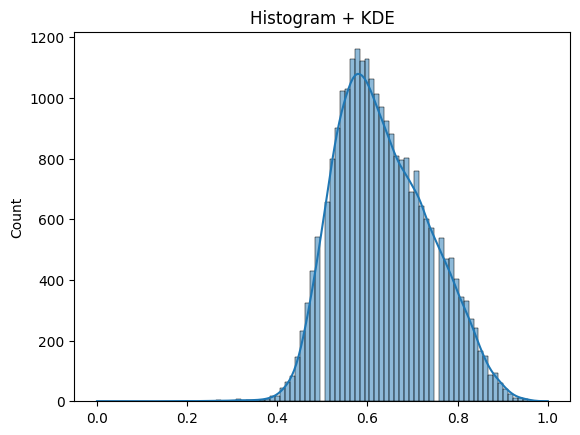

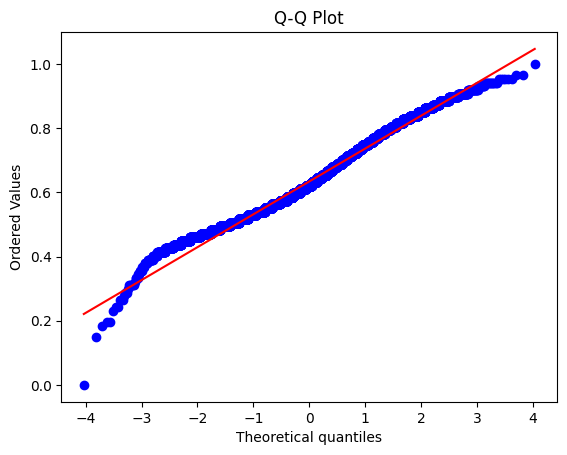

ADF Statistic: -3.334557860734752
p-value: 0.013402657865071882
Used Lags: 48
Number of Observations: 25069

Interpretation:
The p-value is 0.0134, which is less than 0.05.
This means the series is likely stationary.


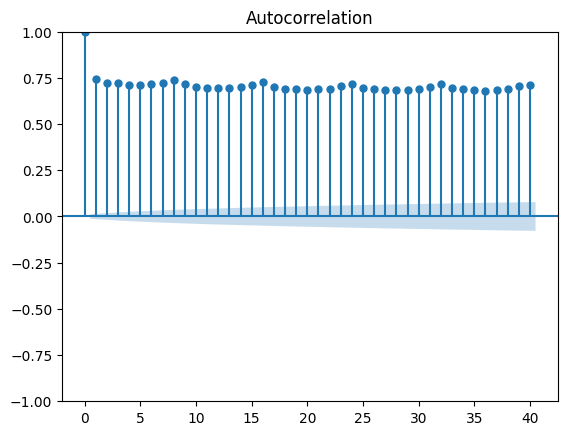

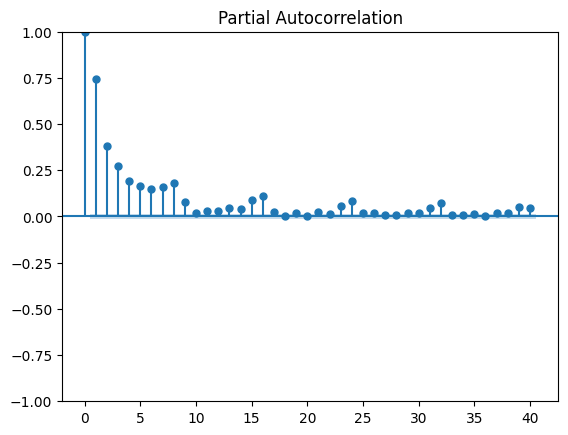

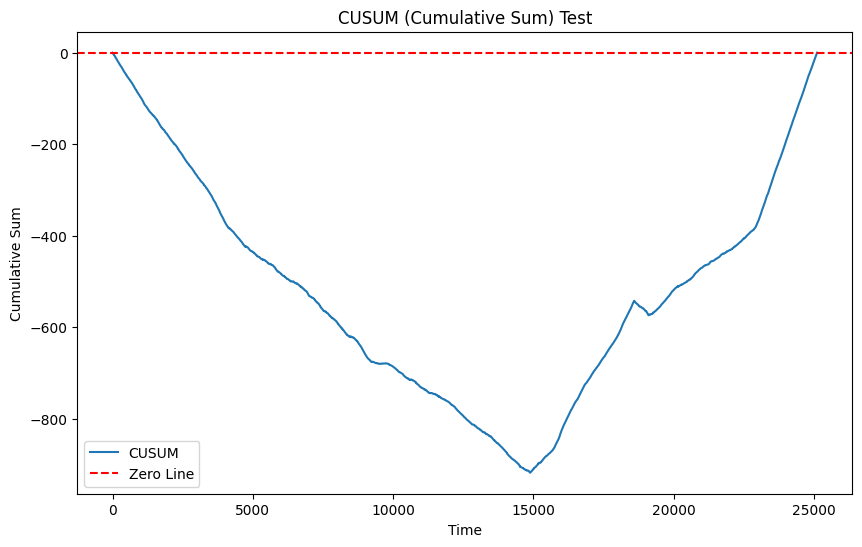

In [5]:
from evaluation import statests
import importlib
importlib.reload(statests)
statests.test_autoregression(inclination_toBD_scaled)
#statests.breakpoints(inclination_toBD_original_scaled)


In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.kdeplot(inclination_toBD_original, label="Original", fill=True, alpha=0.4)
sns.kdeplot(inclination_toBD_scaled, label="Scaled", fill=True, alpha=0.4)
#plt.hist(inclination_toBD_original,bins=46,alpha=0.5,label="Original")
#plt.hist(inclination_toBD_original_scaled,bins=46,alpha=0.5, label="Scaled")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Inclination BD Distributions')
plt.legend()
plt.show()

Smoothing

In [15]:

from preprocess import smoothing
import pandas as pd


#methods=['MA', 'Gaussian', 'Wavelet', 'RTS']
datasmoothing = smoothing.DataSmoothing(inclination_toBD_scaled, methods=['RTS'], max_lag=50)
smoothed=datasmoothing.get_smoothed_data()



Smoothing tests

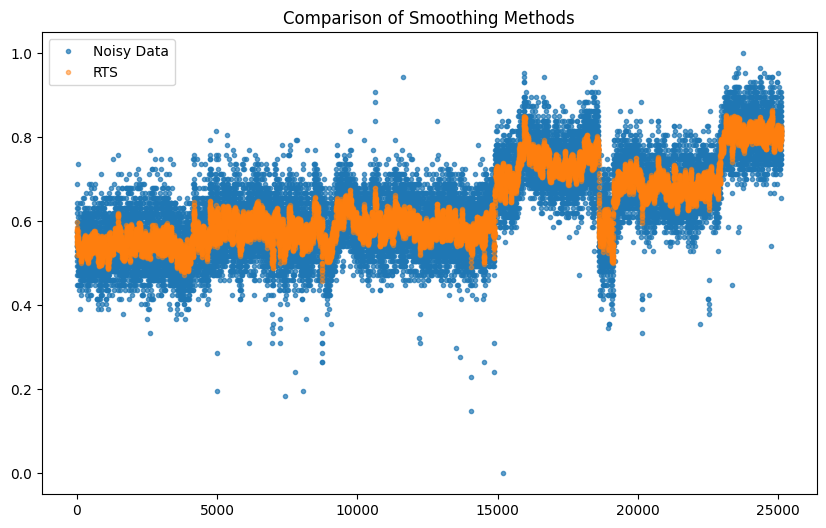

                                 RTS
Autocorrelation (Noisy)     0.745104
Autocorrelation (Smoothed)  0.998038
Best Lag (Noisy)            1.000000
Best Lag (Smoothed)         1.000000
MSE                         0.002618
Standard Deviation Ratio    0.852998
Time                        1.602887
Variance Ratio              0.727606


In [16]:
denoised_data_test = pd.DataFrame(datasmoothing.compare_smoothing_methods())
print(denoised_data_test)

In [ ]:

inclination_toBD_sc_noise=smoothed['Noisy Data']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [ ]:
inclination_toBD_sc_GA=smoothed['Gaussian Filter']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [17]:
inclination_toBD_sc_RTS=smoothed['RTS Smoothing']
#statests.test_autoregression(inclination_toBD_sc_RTS)


In [ ]:
import joblib

# Save any variable (model, scaler, numpy array, dict, etc.)
joblib.dump(inclination_toBD_sc_GA, 'tmp/output1_smoothed_gaus.pkl')
joblib.dump(inclination_toBD_sc_RTS, 'tmp/output1_smoothed_RTS_nsc.pkl')
joblib.dump(inclination_toBD_sc_noise, 'tmp/output1_raw_RTS.pkl')
joblib.dump(inclination_toBD_original, 'tmp/output1_raw.pkl')


#joblib.dump(inclination_toBD_original.values, 'tmp/output1_or.pkl')




Regression

In [ ]:
from regression import regression_pycaret as rpc
import importlib
importlib.reload(rpc)
regression=rpc.RegressionPyCaret(inclination_toBD_sc_RTS)
regression.create_lagged_features()
regression.setup_and_train_models(['lr', 'ridge', 'lightgbm','rf']) #['lr', 'ridge', 'lightgbm', 'rf']
regression_results=regression.predict()
regression_results=pd.DataFrame(regression_results)

In [ ]:
from evaluation import evalresu as er
lr_pred=regression_results[regression_results.columns[0]]
rr_pred=regression_results[regression_results.columns[1]]
lgmb_pred=regression_results[regression_results.columns[2]]
rf_pred=regression_results[regression_results.columns[3]]
y_true=regression_results[regression_results.columns[4]]
print('Ridge regression')
er.evaluate_n_values(y_true,rr_pred,20)
print('Linear regression')

er.evaluate_n_values(y_true,lr_pred,20)
print('Random Forest regression')

er.evaluate_n_values(y_true,rf_pred,20)
print('Lightgmb regression')

er.evaluate_n_values(y_true,lgmb_pred,20)





Auto-regression

general setting, import 

In [18]:
from evaluation import evalresu as er
from tensorflow.keras.models import load_model
from utils.paths import LSTM_MODELS_DIR
import mlflow.keras
from utils.paths import ML_FLOW_DIR
import numpy as np
mlflow.set_tracking_uri(ML_FLOW_DIR)

lstm_model = mlflow.keras.load_model("models:/Direct_LSTM_Model_simple/7") 

def prepare_direct_lstm_deploy(series, input_len=100, output_steps=20):
    """
    Prepare data for Direct Multi-Output LSTM with Train/Val/Test split (60/20/20).
    
    Inputs:
        series (np.ndarray): 1D time series
        input_len (int): Length of input window (e.g., 100)
        output_steps (int): Number of future steps to predict (e.g., 20)
        scale (bool): Whether to normalize the data using StandardScaler
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test, scaler
    """
    
    # Create lagged samples
    X, y = [], []
    for t in range(len(series) - input_len - output_steps + 1):
        X.append(series[t : t + input_len])
        y.append(series[t + input_len : t + input_len + output_steps])
    
    X = np.array(X)[..., np.newaxis]  # (samples, input_len, 1)
    y = np.array(y)  
    return X,y

X,y=prepare_direct_lstm_deploy(inclination_toBD_sc_RTS)
#data=inclination_toBD_sc_tr_sm

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step
  Metric       Value
0    MSE    0.001110
1    MAE    0.025506
2   RMSE    0.033312
3     R2    0.856846
4   MAPE    3.809876
5  SMAPE    3.881370
6    SAE  637.618401


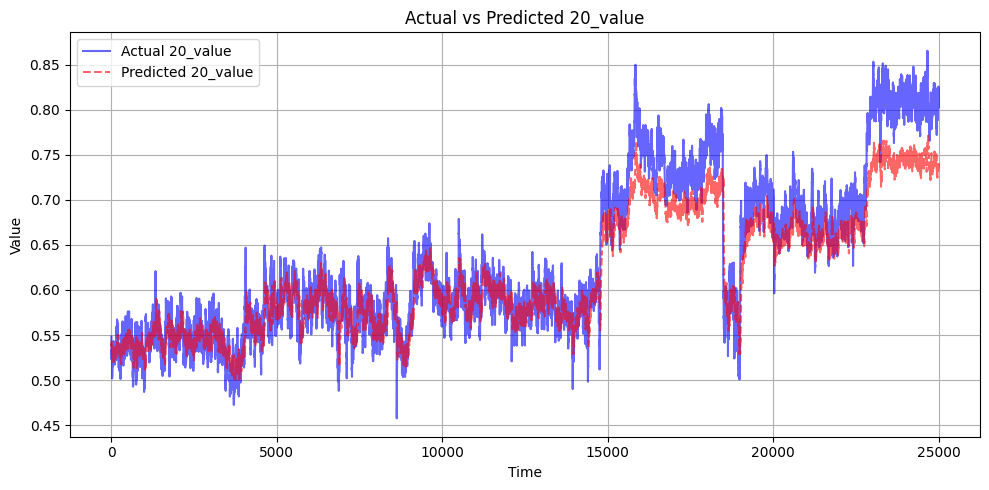

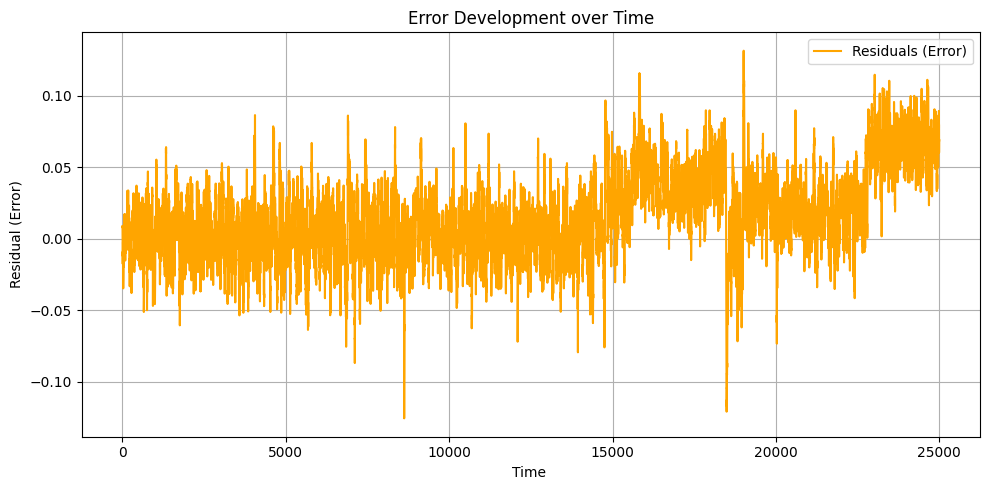

,Metric,Value
0,MSE,0.001110
1,MAE,0.025506
2,RMSE,0.033312
3,R2,0.856846
4,MAPE,3.809876
5,SMAPE,3.881370
6,SAE,637.618401


In [19]:
y_pred=lstm_model.predict(X)
er.evaluate_n_values(y[:,-1],y_pred[:,-1],20) 

Test

In [23]:
np.shape(inclination_toBD_scaled[:-8])

(25110,)

🔄 Initialization: Predicting 100 future values to create residuals dataset...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
✅ Initialization Complete. Residuals Ready.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 

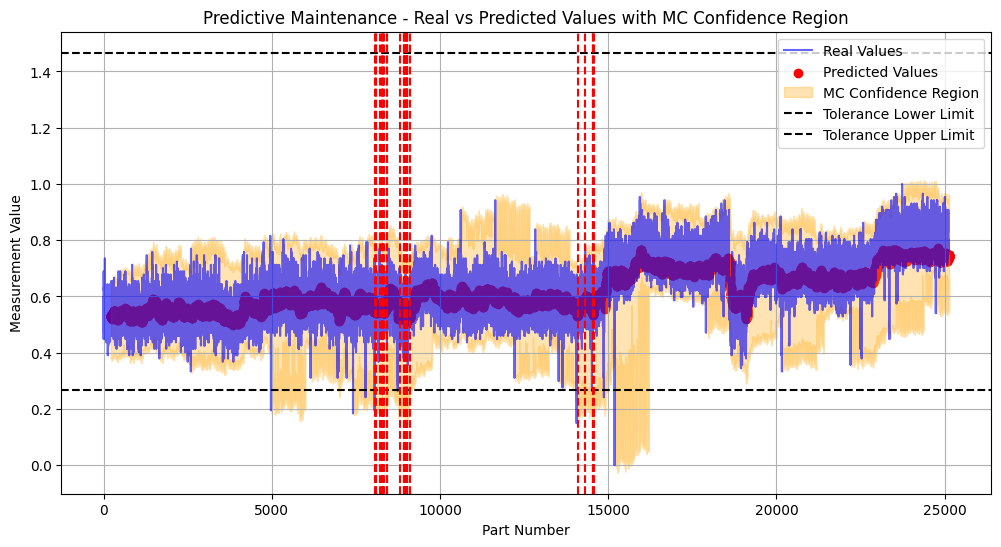

In [31]:
from production import test_prod
import importlib
importlib.reload(test_prod)
from production.test_prod import test_whole
alarm_log=test_whole(lstm_model,
                     inclination_toBD_scaled[:-8],
                     100,
                     20,
                     10,
                     2000,
                     0.26666667,
                    1.46666667,
                    1000,10,0.5)

Models 

In [ ]:
import mlflow.keras
from utils.paths import ML_FLOW_DIR
from tensorflow.keras.utils import plot_model


mlflow.set_tracking_uri(ML_FLOW_DIR)

direct_simple_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_simple/7")
direct_simple_model.summary()
plot_model(direct_simple_model, to_file="export/png/direct_lstm/simple_architecture.png",show_shapes=True, show_layer_names=True)

direct_average_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_average/6")
direct_average_model.summary()
plot_model(direct_average_model, to_file="export/png/direct_lstm/average_architecture.png",show_shapes=True, show_layer_names=True)

direct_advanced_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_advanced/4")
direct_advanced_model.summary()
plot_model(direct_advanced_model, to_file="export/png/direct_lstm/advanced_architecture.png",show_shapes=True, show_layer_names=True)

# plot and save to file

refiner_simple_model=mlflow.keras.load_model(f"models:/Direct_Refiner_Model_simple_lstm_simple/4")
refiner_simple_model.summary()
plot_model(refiner_simple_model, to_file="export/png/hybrid_model/lstm_simple_architecture.png", show_shapes=True, show_layer_names=True)

seq2seq_simple_model=mlflow.keras.load_model(f"models:/Seq2seq_LSTM_Model_simple/4")
seq2seq_simple_model.summary()
plot_model(seq2seq_simple_model, to_file="export/png/seq2seq_lstm/simple_architecture.png", show_shapes=True, show_layer_names=True)

recursive_simple_model=mlflow.keras.load_model(f"models:/Recursive_LSTM_Model_simple/2")
recursive_simple_model.summary()
plot_model(recursive_simple_model, to_file="export/png/recursive_lstm/simple_architecture.png", show_shapes=True, show_layer_names=True)

